In [4]:
import os
os.getcwd()

'C:\\Users\\desti'

In [5]:
import pandas as pd


ModuleNotFoundError: No module named 'yfinance'

In [7]:
!pip install yfinance


In [8]:
import yfinance as yf
import pandas as pd

# Download Apple stock data for January 2024
data = yf.download("AAPL", start="2024-01-01", end="2024-02-01")
data.head()


C:\Users\desti\AppData\Local\Temp\ipykernel_14828\4279624257.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2024-01-01", end="2024-02-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2024-01-02,184.081497,186.857993,182.346189,185.578815,82488700
2024-01-03,182.703156,184.319476,181.890032,182.673409,58414500
2024-01-04,180.382828,181.552914,179.361476,180.620803,71983600
2024-01-05,179.658936,181.225673,178.657420,180.462148,62379700
2024-01-08,184.002182,184.041855,179.976269,180.561312,59144500


In [9]:
import yfinance as yf
import pandas as pd
import os

In [11]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")
    

In [ ]:
sp500.index = pd.to_datetime(sp500.index)

In [12]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-08-11 00:00:00-04:00,6389.669922,6407.250000,6364.060059,6373.450195,4652400000,0.0,0.0
2025-08-12 00:00:00-04:00,6395.169922,6446.549805,6385.759766,6445.759766,5135300000,0.0,0.0
2025-08-13 00:00:00-04:00,6462.669922,6480.279785,6445.020020,6466.580078,5195950000,0.0,0.0


<Axes: xlabel='Date'>

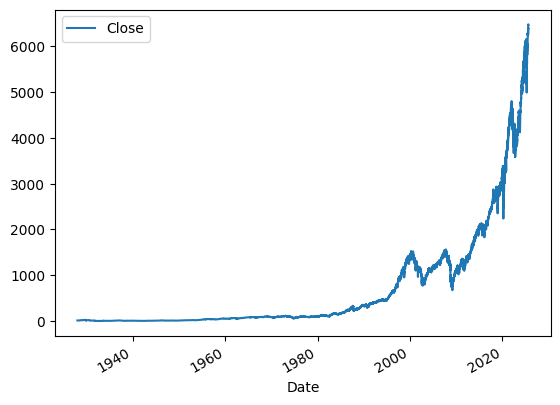

In [13]:
sp500.plot.line(y="Close", use_index=True)

In [14]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [15]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [16]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [17]:
sp500 = sp500.loc["1990-01-01":].copy()

In [47]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=1000, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Open", "Volume", "High", "Low"]
model.fit(train[predictors], train["Target"])

,n_estimators,1000
,criterion,'gini'
,max_depth,None
,min_samples_split,100
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [23]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5806451612903226

<Axes: xlabel='Date'>

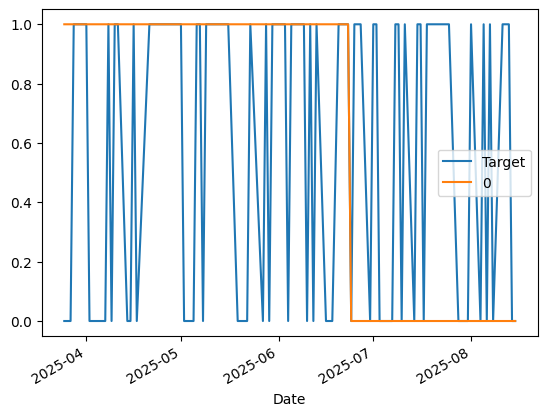

In [26]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [27]:
def predict (train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis =1)
    return combined

In [28]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i: (i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [29]:
predictions = backtest(sp500, model, predictors)

In [31]:
predictions["Predictions"].value_counts()

Predictions
0    3763
1    2709
Name: count, dtype: int64

In [32]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5271317829457365

In [33]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.536774
0    0.463226
Name: count, dtype: float64

In [34]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [35]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [36]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-11 00:00:00-04:00,6389.669922,6407.250000,6364.060059,6373.450195,4652400000,6445.759766,1,0.998746,1.0,1.003783,2.0,1.038191,34.0,1.087004,143.0,1.328752,528.0
2025-08-12 00:00:00-04:00,6395.169922,6446.549805,6385.759766,6445.759766,5135300000,6466.580078,1,1.005641,1.0,1.010506,3.0,1.048464,34.0,1.098512,143.0,1.343268,529.0
2025-08-13 00:00:00-04:00,6462.669922,6480.279785,6445.020020,6466.580078,5195950000,6468.540039,1,1.001612,2.0,1.009922,3.0,1.050404,34.0,1.101285,143.0,1.347026,530.0


In [37]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [48]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [49]:
predictions = backtest(sp500, model, new_predictors)

In [50]:
predictions["Predictions"].value_counts()

Predictions
0.0    4862
1.0     610
Name: count, dtype: int64

In [51]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5819672131147541

In [52]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.546235
0    0.453765
Name: count, dtype: float64

In [54]:
predictions


,Target,Predictions
Date,,
2003-11-14 00:00:00-05:00,0,0.0
2003-11-17 00:00:00-05:00,0,0.0
2003-11-18 00:00:00-05:00,1,0.0
2003-11-19 00:00:00-05:00,0,0.0
2003-11-20 00:00:00-05:00,1,0.0
...,...,...
2025-08-11 00:00:00-04:00,1,0.0
2025-08-12 00:00:00-04:00,1,0.0
2025-08-13 00:00:00-04:00,1,0.0
